### LSTM


In [189]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from utils import plot_loss_epoch

### Load data


In [190]:
bidding_area = 5

df = pd.read_csv(f"data/NO{bidding_area}.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
df = df[["consumption"]]

df

,consumption
timestamp,
2017-05-01 00:00:00+00:00,1609.089000
2017-05-01 01:00:00+00:00,1623.485000
2017-05-01 02:00:00+00:00,1634.128000
2017-05-01 03:00:00+00:00,1647.906000
2017-05-01 04:00:00+00:00,1679.176000
...,...
2023-12-31 19:00:00+00:00,2224.449164
2023-12-31 20:00:00+00:00,2175.957992
2023-12-31 21:00:00+00:00,2137.724404


### Splitting data


In [191]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=False)

df_train

,consumption
timestamp,
2017-05-01 00:00:00+00:00,1609.089000
2017-05-01 01:00:00+00:00,1623.485000
2017-05-01 02:00:00+00:00,1634.128000
2017-05-01 03:00:00+00:00,1647.906000
2017-05-01 04:00:00+00:00,1679.176000
...,...
2022-09-24 22:00:00+00:00,1584.290812
2022-09-24 23:00:00+00:00,1568.327469
2022-09-25 00:00:00+00:00,1559.984348


### Normalization


In [192]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

df_train

,consumption
timestamp,
2017-05-01 00:00:00+00:00,-0.917796
2017-05-01 01:00:00+00:00,-0.871117
2017-05-01 02:00:00+00:00,-0.836607
2017-05-01 03:00:00+00:00,-0.791932
2017-05-01 04:00:00+00:00,-0.690539
...,...
2022-09-24 22:00:00+00:00,-0.998204
2022-09-24 23:00:00+00:00,-1.049966
2022-09-25 00:00:00+00:00,-1.077018


### Define model


In [193]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            device=device, input_size=1, hidden_size=64, num_layers=1, batch_first=True
        )
        self.linear1 = nn.Linear(64 * 100, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, x):
        hidden_state = torch.zeros(1, x.shape[0], 64).to(device)
        cell_state = torch.zeros(1, x.shape[0], 64).to(device)

        hidden = (hidden_state, cell_state)

        x, _ = self.lstm(x, hidden)
        x = x.contiguous().view(x.shape[0], -1)
        x = torch.relu(self.linear1(x))
        return self.linear2(x)


model = LSTM().to(device)
model

LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear1): Linear(in_features=6400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)

### Create dataset for seqence of consumption feature


In [194]:
class SequenceDataset(Dataset):
    def __init__(self, df, time_window: int, padding: int):
        self.df = df
        self.time_window = time_window
        self.padding = padding

    def __len__(self):
        return len(self.df) - self.time_window

    def __getitem__(self, idx):
        sequence = torch.tensor(
            self.df[idx : idx + self.time_window].values.astype(np.float32)
        )
        target = torch.tensor(
            self.df[
                idx + self.time_window : idx + self.time_window + self.padding
            ].values.astype(np.float32)
        )

        return sequence, target

### Create loaders with dataset


In [195]:
tw = 100
pw = 1


train_dataset = SequenceDataset(df_train, time_window=tw, padding=pw)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

val_dataset = SequenceDataset(df_val, time_window=tw, padding=pw)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = SequenceDataset(df_test, time_window=tw, padding=pw)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [196]:
next(model.parameters()).device

device(type='mps', index=0)

### Loss function and optimizer


In [197]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training and validation


In [198]:
epochs = 5

losses = []
losses_show = []
val_losses = []

for e in range(epochs):
    model.train()
    epoch_loss = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device).squeeze()

        optimizer.zero_grad()

        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())

        # after 20 iterations, show the average loss of last 20
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    model.eval()
    val_loss = []
    for X, y in val_loader:
        X, y = X.to(device), y.to(device).squeeze()

        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {e+1}, Loss: {sum(epoch_loss) / len(epoch_loss)}")
    print(f"Val loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)

Epoch 1, Loss: 0.023525557379953835
Val loss: 0.007791544614440721
Epoch 2, Loss: 0.007560912677043352
Val loss: 0.007887842331764212
Epoch 3, Loss: 0.006713234103391411
Val loss: 0.004669752748544264
Epoch 4, Loss: 0.006422388405292383
Val loss: 0.004877315102411168
Epoch 5, Loss: 0.0061971466038073224
Val loss: 0.004638712732439502


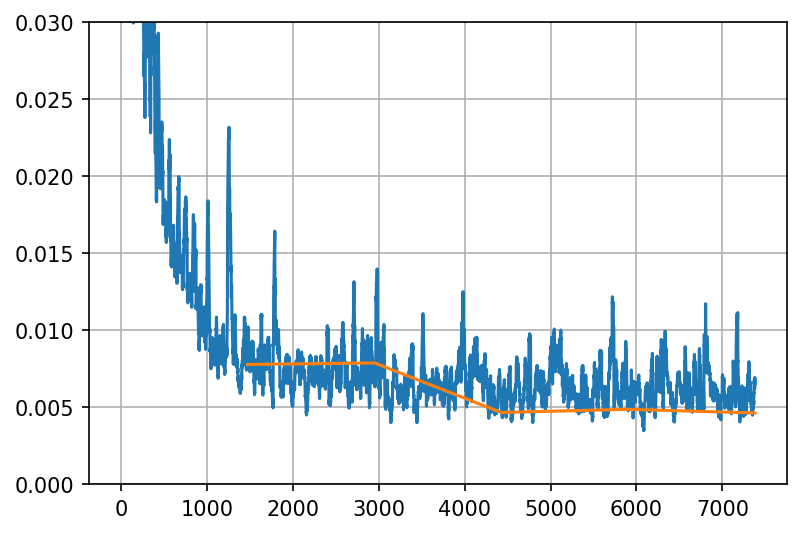

In [199]:
plot_loss_epoch(losses_show, val_losses)

### Testing using n in, 1 out


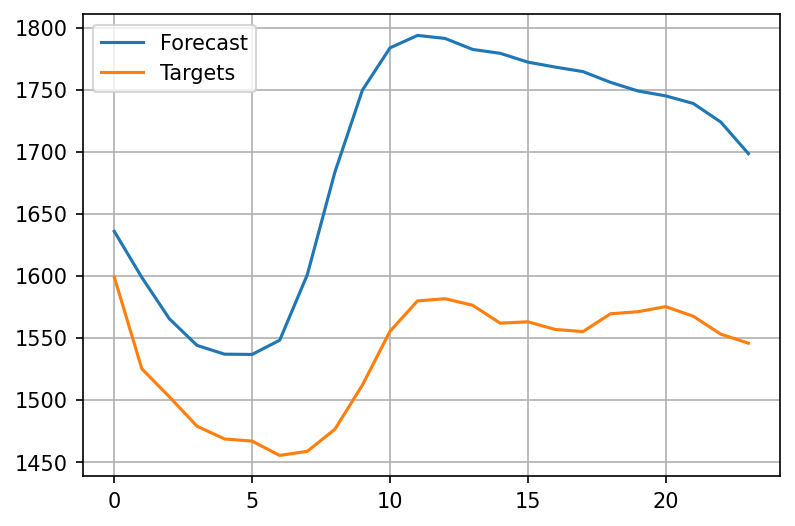

In [200]:
start_point = 1500
tw = 100
fw = 24

historic_data = list(df_test.copy(deep=True)["consumption"])[
    start_point : start_point + tw + fw
]  # test data from start point to 24 hours after sequence end
targets = copy.deepcopy(historic_data)[
    tw : tw + fw
]  # targets are the last 24 rows of the historic data

predictions = []

for i in range(fw):
    x = np.array(historic_data[i : tw + i]).reshape(
        -1, 1
    )  # input sequence (without the last 24)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    pred = model(x)  # this is the 1 out used in next input

    predictions.append(pred.item())

    historic_data[-fw + i] = (
        pred.item()
    )  # append the prediction to the historic data to be used for next prediction

predictions = (
    np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
)
targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()